In [1]:
import pywt
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense , Input , LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras import regularizers

In [2]:
def wavelet_transform(df):
    ca , cb, cc , cd = pywt.wavedec(df['price'].values, 'haar', level = 3)
    cat = pywt.threshold(ca, np.std(ca), mode = 'soft')
    cbt = pywt.threshold(cb, np.std(cb), mode = 'soft')
    cct = pywt.threshold(cc, np.std(cc), mode = 'soft')
    cdt = pywt.threshold(cd, np.std(cd), mode = 'soft')
    coeff = [cat , cbt, cct , cdt]
    return pywt.waverec(coeff, 'haar')

def get_sample(df, length, temporal_horizon):

    temporal_horizon = temporal_horizon - 1
    last_possible = df.shape[0] - temporal_horizon - length

    random_start = np.random.randint(0, last_possible)
    X_sample = df.drop(columns = 'price')[random_start: random_start+length].values
    y_sample = df['price'][random_start+length: random_start+length+temporal_horizon+1]
    
   # if y_sample != y_sample:
        #X_sample, y_sample = get_sample(df, length, temporal_horizon)
    
    return X_sample, y_sample

def get_X_y(df, temporal_horizon, length_of_sequences):
    X, y = [], []

    for len_ in length_of_sequences:
        xi, yi = get_sample(df, len_, temporal_horizon)
        X.append(xi)
        y.append(yi)
        
    return X, np.array(y)


def autoencoder(features):
    input_data = Input(shape=(1, features))
    encoded1 = Dense(features, activation="relu", activity_regularizer=regularizers.l2(0))(input_data)
    one_l = Dense(1, activation="relu", activity_regularizer=regularizers.l2(0))(encoded1)
    decoded = Dense(features, activation="linear", activity_regularizer=regularizers.l2(0))(one_l)
    autoencoder = Model(inputs=input_data, outputs=decoded)
    encoder = Model(input_data, one_l)
    autoencoder.compile(loss = 'mse', optimizer = 'rmsprop',metrics = ['mae'])
    return autoencoder , encoder

## DATA

In [3]:
df  = pd.read_csv('ma_ema.csv')
df.set_index('date', inplace = True)
df_test = df[2970:3361]
df = df[:3000]

In [4]:
df['price'] = wavelet_transform(df)
df.dropna(inplace = True)

## AUTOENCODER

In [5]:
autoencoder , encoder = encoder(14)

In [7]:
X = np.array(df)
X = X.reshape(len(X), 1, 14)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss',mode = 'min' , verbose = 1, patience = 20, restore_best_weights = True)
history = autoencoder.fit(X,X,
                    validation_split = 0.3,
                   callbacks = [es], 
                   epochs = 1000, 
                   batch_size = 64,
                   shuffle = True)

Epoch 1/1000
32/32 [==============================] - 0s 7ms/step - loss: 0.0094 - mae: 0.0490 - val_loss: 0.0154 - val_mae: 0.0616
Epoch 2/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0082 - mae: 0.0470 - val_loss: 0.0128 - val_mae: 0.0586
Epoch 3/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0073 - mae: 0.0458 - val_loss: 0.0109 - val_mae: 0.0555
Epoch 4/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0069 - mae: 0.0459 - val_loss: 0.0096 - val_mae: 0.0529
Epoch 5/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0067 - mae: 0.0459 - val_loss: 0.0092 - val_mae: 0.0521
Epoch 6/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0065 - mae: 0.0454 - val_loss: 0.0092 - val_mae: 0.0508
Epoch 7/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0064 - mae: 0.0444 - val_loss: 0.0090 - val_mae: 0.0500
Epoch 8/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.

32/32 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0342 - val_loss: 0.0054 - val_mae: 0.0444
Epoch 63/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0340 - val_loss: 0.0051 - val_mae: 0.0429
Epoch 64/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0342 - val_loss: 0.0053 - val_mae: 0.0442
Epoch 65/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0340 - val_loss: 0.0050 - val_mae: 0.0429
Epoch 66/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0342 - val_loss: 0.0051 - val_mae: 0.0434
Epoch 67/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0342 - val_loss: 0.0049 - val_mae: 0.0432
Epoch 68/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0342 - val_loss: 0.0049 - val_mae: 0.0424
Epoch 69/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0030 -

32/32 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0344 - val_loss: 0.0045 - val_mae: 0.0421
Epoch 124/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0344 - val_loss: 0.0045 - val_mae: 0.0420
Epoch 125/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0344 - val_loss: 0.0044 - val_mae: 0.0414
Epoch 126/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0346 - val_loss: 0.0047 - val_mae: 0.0433
Epoch 127/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0343 - val_loss: 0.0045 - val_mae: 0.0421
Epoch 128/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0345 - val_loss: 0.0045 - val_mae: 0.0425
Epoch 129/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0344 - val_loss: 0.0046 - val_mae: 0.0423
Epoch 130/1000
32/32 [==============================] - 0s 1ms/step - loss: 0

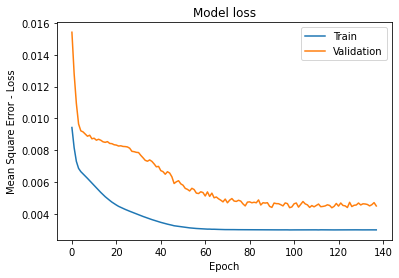

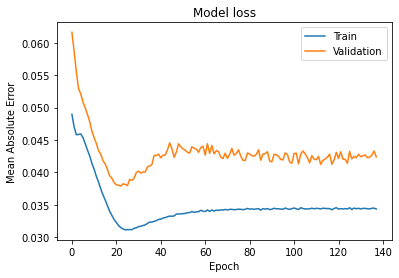

In [9]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model loss')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
plot_loss(history)

In [10]:
X_encode = autoencoder.predict(X)
X_encode.shape = (X_encode.shape[0], X_encode.shape[2])
new_df = pd.DataFrame(X_encode)
df.reset_index(inplace = True)
new_df['price'] = df['price']

In [11]:
n_days = 30
length = 30
length_of_sequences = [length for x in range(3500)]

X_train, y_train = get_X_y(new_df, n_days, length_of_sequences)

In [12]:
def init_model() :
    model = Sequential()               
    model.add(LSTM(150,activation = 'tanh',input_shape=(length, 14),return_sequences = True))
    model.add(Dropout(0.5))  
    model.add(Bidirectional(LSTM(120, activation = 'tanh',return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(100,activation = 'tanh',return_sequences = True)))
    model.add(Dropout(0.5))
    model.add(LSTM(80,activation = 'tanh'))
    model.add(Dense(60,activation = 'relu'))     
    model.add(Dense(n_days,activation = 'linear'))

    model.compile(loss = 'mse', optimizer = 'rmsprop',metrics = ['mae'])

    return model

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
model = init_model()
es = EarlyStopping(monitor = 'val_loss',mode = 'min' , verbose = 1, patience = 20, restore_best_weights = True)
history = model.fit(np.array(X_train), y_train,
                    validation_split = 0.3,
                   callbacks = [es], 
                   epochs = 1000, 
                   batch_size = 32)
                   #shuffle = True)

Epoch 1/1000
77/77 [==============================] - 7s 93ms/step - loss: 0.0183 - mae: 0.0965 - val_loss: 0.0172 - val_mae: 0.1126
Epoch 2/1000
77/77 [==============================] - 6s 73ms/step - loss: 0.0112 - mae: 0.0814 - val_loss: 0.0098 - val_mae: 0.0766
Epoch 3/1000
77/77 [==============================] - 6s 73ms/step - loss: 0.0099 - mae: 0.0772 - val_loss: 0.0083 - val_mae: 0.0715
Epoch 4/1000
77/77 [==============================] - 6s 74ms/step - loss: 0.0085 - mae: 0.0708 - val_loss: 0.0124 - val_mae: 0.0842
Epoch 5/1000
77/77 [==============================] - 6s 72ms/step - loss: 0.0075 - mae: 0.0647 - val_loss: 0.0075 - val_mae: 0.0686
Epoch 6/1000
77/77 [==============================] - 6s 73ms/step - loss: 0.0070 - mae: 0.0625 - val_loss: 0.0095 - val_mae: 0.0777
Epoch 7/1000
77/77 [==============================] - 6s 72ms/step - loss: 0.0067 - mae: 0.0612 - val_loss: 0.0070 - val_mae: 0.0629
Epoch 8/1000
77/77 [==============================] - 6s 73ms/step - 

77/77 [==============================] - 7s 94ms/step - loss: 0.0013 - mae: 0.0240 - val_loss: 0.0011 - val_mae: 0.0207
Epoch 63/1000
77/77 [==============================] - 6s 82ms/step - loss: 0.0016 - mae: 0.0247 - val_loss: 0.0013 - val_mae: 0.0230
Epoch 64/1000
77/77 [==============================] - 6s 76ms/step - loss: 0.0014 - mae: 0.0236 - val_loss: 0.0027 - val_mae: 0.0317
Epoch 65/1000
77/77 [==============================] - 6s 75ms/step - loss: 0.0013 - mae: 0.0238 - val_loss: 0.0013 - val_mae: 0.0232
Epoch 66/1000
77/77 [==============================] - 6s 74ms/step - loss: 0.0014 - mae: 0.0235 - val_loss: 0.0015 - val_mae: 0.0258
Epoch 67/1000
77/77 [==============================] - 6s 78ms/step - loss: 0.0014 - mae: 0.0230 - val_loss: 0.0012 - val_mae: 0.0231
Epoch 68/1000
77/77 [==============================] - 6s 75ms/step - loss: 0.0013 - mae: 0.0230 - val_loss: 0.0012 - val_mae: 0.0232
Epoch 69/1000
77/77 [==============================] - 6s 75ms/step - loss: 

77/77 [==============================] - 9s 121ms/step - loss: 5.5828e-04 - mae: 0.0148 - val_loss: 7.4454e-04 - val_mae: 0.0169
Epoch 122/1000
77/77 [==============================] - 9s 122ms/step - loss: 7.0828e-04 - mae: 0.0151 - val_loss: 5.9329e-04 - val_mae: 0.0149
Epoch 123/1000
77/77 [==============================] - 9s 122ms/step - loss: 5.9865e-04 - mae: 0.0148 - val_loss: 8.1245e-04 - val_mae: 0.0179
Epoch 124/1000
77/77 [==============================] - 12s 151ms/step - loss: 4.9801e-04 - mae: 0.0144 - val_loss: 5.2840e-04 - val_mae: 0.0137
Epoch 125/1000
77/77 [==============================] - 10s 128ms/step - loss: 5.2857e-04 - mae: 0.0147 - val_loss: 5.8092e-04 - val_mae: 0.0149
Epoch 126/1000
77/77 [==============================] - 12s 150ms/step - loss: 5.3541e-04 - mae: 0.0142 - val_loss: 4.9629e-04 - val_mae: 0.0135
Epoch 127/1000
77/77 [==============================] - 9s 122ms/step - loss: 5.2238e-04 - mae: 0.0146 - val_loss: 5.9630e-04 - val_mae: 0.0142
Epoc

77/77 [==============================] - 6s 72ms/step - loss: 3.1654e-04 - mae: 0.0112 - val_loss: 4.2718e-04 - val_mae: 0.0117
Epoch 179/1000
77/77 [==============================] - 6s 72ms/step - loss: 3.1618e-04 - mae: 0.0110 - val_loss: 4.1034e-04 - val_mae: 0.0115
Epoch 180/1000
77/77 [==============================] - 6s 72ms/step - loss: 3.2600e-04 - mae: 0.0112 - val_loss: 4.4211e-04 - val_mae: 0.0118
Epoch 181/1000
77/77 [==============================] - 6s 72ms/step - loss: 3.2777e-04 - mae: 0.0115 - val_loss: 4.9758e-04 - val_mae: 0.0132
Epoch 182/1000
77/77 [==============================] - 6s 73ms/step - loss: 3.2857e-04 - mae: 0.0113 - val_loss: 4.4050e-04 - val_mae: 0.0122
Epoch 183/1000
77/77 [==============================] - 5s 71ms/step - loss: 3.8198e-04 - mae: 0.0120 - val_loss: 4.6685e-04 - val_mae: 0.0129
Epoch 184/1000
77/77 [==============================] - 6s 73ms/step - loss: 3.6373e-04 - mae: 0.0111 - val_loss: 4.5254e-04 - val_mae: 0.0125
Epoch 185/1000

77/77 [==============================] - 6s 74ms/step - loss: 2.7656e-04 - mae: 0.0100 - val_loss: 4.2002e-04 - val_mae: 0.0116
Epoch 00235: early stopping


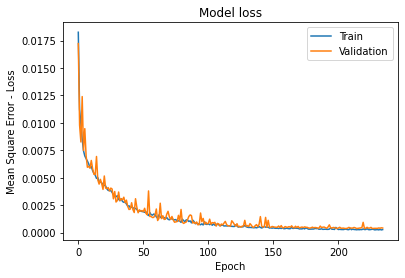

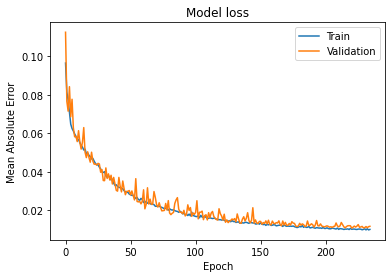

In [14]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model loss')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
plot_loss(history)

## TEST

In [15]:
df_test_n = df_test.copy()
df_test_n['price'] = wavelet_transform(df_test_n)[:len(df_test_n)]

df_test = df_test[length:]

prediction = []
for x in range(0,12):
    n = 30*x 
    i = 30 + 30*x
    encode = autoencoder.predict(df_test_n[n:i])
    encode.shape = (1,encode.shape[0], encode.shape[1])
    predict = model.predict(encode)
    prediction.append(predict)

In [16]:
prediction = np.array(prediction)
prediction.shape = (360)

ValueError: cannot reshape array of size 120 into shape (360,)

In [ ]:
plt.figure(figsize = (18, 7))
plt.plot(prediction, label = 'prediction')
plt.plot(df_test['price'], label = 'truth')
plt.legend()